In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

import sys
import json
from statistics import mean
sys.path.append('../src/')
import utils.eval.rewards as rw
from utils.eval.rewards import get_synth_rewards
from utils.data.prompt_utils import splitter
from tqdm import tqdm
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset, concatenate_datasets
import seaborn as sns
from utils.data.prompt_utils import qaform, splitter
from process_plot import loadf, makengs, plot_methods, intervmean, combineall
import torch

In [34]:
mathdn = pd.read_json("../outputs/results/dynarmlogs/math/mathbigdata1b_1bbig_128_8_seed3.jsonl", orient='records', lines=True)

In [35]:
mathdn

,texts,rewards,golds,call
0,[Question: (((4 + 9) - 5) - 2) = \n\nAnswer: ...,"[1.734375, 1.3359375]","[-13.0, -16.0]","[1, 1]"
1,[Question: (((2 - 5) + 8) * 5) = \n\nAnswer: ...,"[1.21875, 1.296875]","[0.0, -16.0]","[1, 1]"
2,[Question: (((7 + 5) * (8 - 3)) - 9) = \n\nAns...,"[1.3984375, 1.2421875]","[-27.0, 0.0]","[1, 1]"
3,[Question: (((5 * 5) + 4) * 5) = \n\nAnswer: ...,"[1.15625, 1.3203125]","[-21.0, -15.0]","[1, 1]"
4,[Question: (((3 + 6) * 2) * ((5 - 8) - (5 * 2)...,"[0.6953125, -0.87890625]","[-31.0, -54.0]","[1, 1]"
...,...,...,...,...
15995,[Question: (((6 - 7) + 8) + ((7 + 2) * (1 - 3)...,"[1.578125, 1.546875]","[0.0, 0.0]","[1000, 1000]"
15996,[Question: (((6 * 3) * (1 - 9)) + 4) = \n\nAns...,"[1.1484375, 1.265625]","[-9.0, -9.0]","[1000, 1000]"
15997,[Question: (((2 * 9) + 7) + 2) = \n\nAnswer: ...,"[1.3359375, 1.2421875]","[-6.0, 0.0]","[1000, 1000]"
15998,[Question: (((2 + 8) - 2) - 4) = \n\nAnswer: ...,"[1.2109375, 1.2109375]","[0.0, 0.0]","[1000, 1000]"


In [40]:
ind = 1000

q, a = splitter(mathdn['texts'][ind][0])
print("\\midrule")
print(q, " & ", a, " & ", str(mathdn['golds'][ind][0]), " \\\\")
q, a = splitter(mathdn['texts'][ind][1])
print("\\midrule")
print(q, " & ", a, " & ", str(mathdn['golds'][ind][1]), " \\\\")


\midrule
(((5 + 1) * (3 + 8)) * 3) =  &  ((6 * (3 + 8)) * 3) = ((6 * 11) * 3) = (66 * 3) = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 =  &  0.0  \\
\midrule
(((5 + 1) * (3 + 8)) * 3) =  &  ((6 * (3 + 8)) * 3) = ((6 * 11) * 3) = (66 * 3) = 198 = 198 = 198 =198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 = 198 =  &  0.0  \\


In [ ]:
current_device=0

In [ ]:
rw.likemod = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b", device_map=current_device, torch_dtype=torch.bfloat16).eval()
rw.liketok = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
rw.slikemod = AutoModelForCausalLM.from_pretrained("facebook/opt-125m", device_map=current_device, torch_dtype=torch.bfloat16).eval()
rw.sliketok = AutoTokenizer.from_pretrained("facebook/opt-125m")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
with open("trainresults.json", "r") as f: 
    injsons = json.load(f)

injsons.keys()

In [ ]:
# 'bagofwords':"../../rlhf-length-biases/outputs/rollouts/contextpos32ppologged.jsonl"
# approaches = ['mainbaselines', 'mainresults', 'updatedppos', 'opobaseline']
# approaches = ['mainresults', 'oldbases'] # for UF plot
# norescore = [False, False, False, False]
# approaches = ['mainresults', 'selfreward', "dpoapi"]
# approaches = ['selfreward']
# norescore = [True]

approaches = ['mainresults']
useselfrewards = [False, False, False, False]
# approaches =['accshow']
norescore = [True]
mratios = {'bagofwords':2, 'nouns':0.4, 'math':2, 'cdist':1, 'ultra':8}
dset = "cdist"
allngs, allaccs = [], []

In [ ]:
# loop through all the approaches we want to plot / compare, add them to the things
for i in range(len(approaches)):
    a = approaches[i]
    fnametmp = injsons[a][dset]
    print(fnametmp)
    gf = None 
    if norescore[i]:
        gf = lambda lis: rw.get_synth_rewards(lis, dset if dset!="cdist" else "contrastivedistill")
        print("NRI")
    # have a  list of stuff, TODO there's a better way to check this
    if len(fnametmp)<5:
        allmethngs = []
        allmethaccs = []
        for d in fnametmp:
            tmpmethod = loadf(d, gf, useselfrewards[i])
            methngs, methaccs = makengs(tmpmethod)
            allmethngs.append(methngs)
            allmethaccs.append(methaccs)
        ngstmp = combineall(allmethngs)
        accstmp = combineall(allmethaccs)
    else:
        tmpbase = loadf(fnametmp, gf,useselfrewards[i])       
        if len(tmpbase)>100000:
            # take last 64k in edge cases?
            tmpbase = tmpbase.iloc[-64000:].reset_index()
            ngstmp, accstmp = makengs(tmpbase)
        tmpbase = tmpbase.reset_index(drop=True)
        ngstmp, accstmp = makengs(tmpbase)
        ngstmp = list([mean(m) for m in ngstmp])
        
    allngs.append(ngstmp)
    allaccs.append(accstmp)

In [ ]:
# tmpbase.to_json("../../rlhf-length-biases/outputs/rollouts/nouns/dponounsynth_125magnfa_ppo_magnouns.jsonl", orient='records', lines=True)

In [ ]:
# tmpbase.to_json("../outputs/results/rollouts//contrastivedistill/ppo_cdist_initrmbaselineproc.jsonl", orient='records', lines=True)

In [ ]:
"../../rlhf-length-biases/outputs/rollouts//dponounsynth_125magnfa_ppo_magnouns.jsonl"

In [ ]:
allaccs = allaccs[1:]

In [ ]:
tmpmethod = loadf("../outputs/results/rollouts/contrastivedistill/ppo_dpoplusfullrm.jsonl", None, False)

In [ ]:
tmpmethod

In [ ]:
def printrow(indf, ind):
    row = indf.iloc[ind]
    for i in range(len(row['texts'])):
        q, a = splitter(row['texts'][i])
        print(q + "& " + a + " & " + str(row['golds'][i]) + "\\\\")

In [ ]:
printrow(tmpmethod, 200)

In [ ]:
allngs = allngs[-3:]
allaccs = allaccs[-3:]

In [ ]:
[len(l) for l in allmethaccs]

In [ ]:
# labels = ["OPO with gold", "ARMoUR", "PPO (50K)", "OPO (50K)"]
# ratios = [8, 2, 2, 2]
# intervs = [20, 500, 50, 50]
# windows = [50, 500, 50, 50]
labels = ["D2PO", "OPO (gold)", "D2PO (DPO)"]
ratios = [.25, .25, 1]
intervs = [10, 10, 40]
windows = [50, 50, 100]
# labels = ["RM", "Self-Reward", "DPO"]
# ratios = [0.25, 0.25]
# intervs = [5, 10, 10]

# windows = [100, 500, 50]

In [ ]:
pdict = {labels[a]:(ratios[a], intervmean(allngs[a], intervs[a] , 50)) for a in range(len(approaches))}
plot_methods(pdict, xlabel="Preferences Used", ylabel="Gold Reward", setname="UltraFeedback", fname ='ultranwmain.pdf', dpoline=4.19)

In [ ]:
labels = ["OPT (static RM)", "D3PO (self-reward)", "D2PO (DPO)"]
ratios = [.34, 1, 1]
intervs = [20, 10, 400]
windows = [100, 50, 50]

In [ ]:
len(allngs[0])

In [ ]:
labels = ["D2PO", "D2PO (policy reward)", "D2PO (DPO)"]
# ratios = [2, 2, 1]
ratios = [.3, 1, 1]

intervs = [200, 50, 40]
windows = [400, 200, 100]

In [ ]:
pdict = {labels[a]:(ratios[a], intervmean(allaccs[a], intervs[a] , windows[a])) for a in range(len(approaches))}
plot_methods(pdict, xlabel="Policy Steps", ylabel="Reward Accuracy", setname="Nouns", fname="nounaccv3.pdf")

In [ ]:
plot_methods(pdict, xlabel="Policy Steps", ylabel="Gold Reward", setname="Bag of Words")

In [ ]:
tmpbase = loadf(basefs[dset])
if len(tmpbase)>100000:
    tmpbase = tmpbase.iloc[64000:].reset_index()
basengs, baseaccs = makengs(tmpbase)
print("loaded base")
allmethngs = []
allmethaccs = []
# have a  list of stuff, TODO there's a better way to check this
if len(bestmethds[dset])<5:
    for d in bestmethds[dset]:
        tmpmethod = loadf(d)
        methngs, methaccs = makengs(tmpmethod)
        allmethngs.append(methngs)
        allmethaccs.append(methaccs)
        
print("loaded method")

# tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts/math/ppo_goldb8easy4fix.jsonl", orient='records', lines=True, nrows=64000)
# tlog = pd.read_json("../../outputs/bagofwords/dynarmlogs/expbow50_updatereprod_fix.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../../activereprod/active-rlhf/outputs/results/dynarmlogs/math/u/prasanns/research/active-rlhf/outputs/models/math/tiny_rm_rand_subsamp_onlymathreprod3.jsonl", orient='records', lines=True)
# tlog = pd.read_json("../outputs/results/dynarmlogs/.jsonl", orient='records', lines=True)

In [ ]:
tlog = pd.read_json("../../active-rlhf/outputs/results/rollouts//contrastivedistill/ppo_confcdist_goldb8_selfreward.jsonl", orient='records', lines=True, nrows=64000)


In [ ]:
tlog

In [ ]:
ngsdict = {
    'PPO(50K RM)': (basemeans, 2), 
    'Online DPO (Gold)': (methmeans, 2), 
    ""
}
accsdict = {
    'PPO(50K RM)': (basemeans, 2), 
    'Online DPO (Gold)': (methacms, 2), 
}

In [ ]:
# ngsdict['ARMoUR'] = ngsdict['Online DPO (Gold)']
# accsdict['ARMoUR'] = accsdict['Online DPO (Gold)']
accsdict['Online DPO (Gold)'] = (baseacms, 8)
ngsdict['Online DPO (Gold)'] = (basemeans, 8)


In [ ]:
ngsdict['ARMoUR'] = (ngsdict['ARMoUR'] , 2)
ngsdict['Online DPO (Gold)'] = (ngsdict['Online DPO (Gold)'] , 8)

In [ ]:
del accsdict['Online DPO (Gold)']

In [ ]:
ngsdict['ARMoUR'] = ngsdict['ARMoUR'][0]

In [ ]:
tgolds = []
for _, row in tqdm(tmpbase.iterrows()):
    
    tgolds.append(get_synth_rewards([qaform(row['inputs'][i], row['outputs'][i]) for i in range(len(row['inputs']))], 'bagofwords') )

In [ ]:
tmpbase['golds'] = tgolds

In [ ]:
tmpbase

In [ ]:
baseratio = 8

In [ ]:
basengs, baseaccs = makengs(newtest)
methngs, methaccs = makengs(tmpdynarmlogs)

In [ ]:
allmethngs = []

In [ ]:


basemeans = intervmean([mean(m) for m in basengs], 25, 50)
if len(allmethngs)>0:
    methmeans = intervmean(combineall(allmethngs), 25 , 50)
else:
    methmeans = intervmean([mean(m) for m in methngs], 25 , 50)
baseacms = intervmean(baseaccs, 25, 250)
methacms = intervmean(methaccs, 25 , 250)

In [ ]:
mean(methmeans[-20:-10])

In [ ]:
fig = ratio_scatter(basemeans, methmeans, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "Nouns")
# fig = ratio_scatter(basemeans, basemeans, 2000, baseratio, baseratio, "efficientplots/tmp"+".pdf", "tmp")

fig = ratio_scatter(baseacms, methacms, 2000, mratios[dset], mratios[dset], "efficientplots/acc"+dset+".pdf", "Bag of Words", methmax=False, labels=['ARMoUR (spaced out)', 'ARMoUR (normal)'])

In [ ]:
def splitter(inp):
    # qa style
    if ("Question:" in inp) and "Answer:" in inp: 
        instruction, response = inp.split("\n\nAnswer: ")
        instruction = instruction[len("Question: "):]
    # alpacafarm style
    if "### Instruction:" in inp:
        instruction_match = re.search(r'### Instruction:\n(.*?)(### Response:|\Z)', inp, re.DOTALL)
        instruction = instruction_match.group(1).strip() if instruction_match else inp
        # Extract Response
        response_match = re.search(r'### Response:.*?(.*?)(### |\Z)', inp, re.DOTALL)
        response = response_match.group(1).strip() if response_match else ""
    # tulu style
    if "<user>" in inp: 
        q = inp[len("<user>\n"):]
        instruction, response = q.split("\n<assistant>\n")
    
    return instruction, response
# given a starting index (default 0), and some other thing, return the
# better and worse index in that order
def indcomp(rws, sind=0, eind=-1): 
    # extra functionalty
    if eind>=0: 
        return (sind, eind) if rws[sind]>rws[eind] else (eind, sind)
    if rws[0]>rws[1]:
        return 0+sind, 1+sind
    return 1+sind, 0+sind
    
# given a dataframe with a "golds" column, make rollouts into preference data (assume that pairs go together as rollouts)
def dynarm_to_prefs(indf):
    prefdata = []
    for ind, row in indf.iterrows():
        inp = splitter(row['texts'][0])[0]
        resps = [splitter(row['texts'][i])[1] for i in range(2)]
        indj, indk = indcomp(row['golds'], 0)
        tmp = {
            'question': inp,
            'response_j': resps[indj],
            'response_k': resps[indk],
            'score_j': row['golds'][indj], 
            'score_k': row['golds'][indk],
            'magnitude': row['golds'][indj] - row['golds'][indk]
        }
        prefdata.append(tmp)
            
    return Dataset.from_list(prefdata)
    
# get a training set or eval set from some input
def interv_setup(indata, amt=5, start=0, end=(1/16)):
    # Create a mask to identify rows where the two numbers in each list are identical
    mask = indata['golds'].apply(lambda x: x[0] != x[1])
    
    # Filter out rows where numbers are identical
    filtered_df = indata[mask]
    
    # based on old index, not the new thing
    subset = filtered_df.loc[int(len(indata)*start):int(len(indata)*end)]
    return subset.sample(amt)


In [ ]:
for i in range(0, 5):
    t = interv_setup(tmpmethod, 5)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/5set"+str(i))

for i in range(0, 5):
    t = interv_setup(tmpmethod, 50)
    p = dynarm_to_prefs(t)
    print(p[0])
    #p.save_to_disk("../outputs/data/"+dset+"/50set"+str(i))

In [ ]:
t = interv_setup(tmpmethod, 200, (1/16), (2/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/latereval")

t = interv_setup(tmpmethod, 200, (0), (1/16))
p = dynarm_to_prefs(t)
print(p[0])
p.save_to_disk("../outputs/data/"+dset+"/earlyeval")

In [ ]:
fig = ratio_scatter(baseaccs, methaccs, 2000, mratios[dset], mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [ ]:
s2 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl", orient='records', lines=True)
s3 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2.jsonl", orient='records', lines=True)
s4 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefix.jsonl", orient='records', lines=True)

In [ ]:
tmpb = loadf("../outputs/results/rollouts/bagofwords/ppo_conf_newalgo_5testlogrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/bagofwords/bowtiny_rm_conf_newalgo_5testlogrun.jsonl")

In [ ]:
tmpb = loadf("../outputs/results/rollouts/contrastivedistill/ppo_rand_cdist_10_5_logrun.jsonl")
tmpdynarmlogs = loadf("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_logrun.jsonl")

In [ ]:
def newpairdf(tmpdf, rws, fdim=2):
    newdf = tmpdf.copy()
    tot = []
    for r in rws: 
        tot.extend(r)
    newv = []
    for i in range(0, len(tot), fdim):
        newv.append(tot[i:i+fdim])
    mval = min(len(newv), len(newdf))
    print(mval)
    print(len(newdf))
    newdf['rewards'][:min(len(newv), len(newdf))] = newv[:min(len(newv), len(newdf))]
    
    return newdf

newtest = newpairdf(tmpdynarmlogs, tmpb['selfscos'])

In [ ]:
len(tmpb['selfscos'][0])

In [ ]:
fig = ratio_scatter(basemeans, methmeans, 2000, baseratio, mratios[dset], "efficientplots/"+dset+".pdf", "UltraFeedback")

In [ ]:
ngs, accs = makengs(tmp)

In [ ]:
meanngs = list([mean(n) for n in ngs])

In [ ]:
accscatter(meanngs)

In [ ]:
means = [mean(m) for m in ngs]
# means = [mean(m) for m in tmp['rewards']]

interv = 10
mbins = [mean(means[i:i+100]) for i in range(0, len(means), interv)]
plt.scatter(range(len(mbins)), mbins)

In [ ]:
print(max(mbins))
print(mean(mbins[-100:]))

In [ ]:
tmp.iloc[1000:1010]

In [ ]:
means = [mean(m) for m in tmp['golds']]
plt.scatter(range(len(means)), means)

In [ ]:
from os import listdir
import json

In [ ]:
def makeplot(base, key, start=100, end=2000, gap=100):
    mvs = []
    cks = []
    for s in range(start, end+1, gap):
        #print(s)
        fname = base+"/"+key+str(s)+".results"
        # print(fname)
        with open(fname, "r") as f:
            res = json.load(f)
            #print(res)
            mv = mean([m[0] for m in res['truncval']])
            cks.append(s)
            mvs.append(mv)
    return mvs# , cks

In [ ]:
keys = ['ppo_conf_newalgo_5testnewseed3', 'ppo_conf_newalgo_goldb8_1ups', 'ppo_confbow_goldb8_selfreward', "ppo_conf_newalgo_5testnewseed2_dpoapi"]
bowmainres = {
    'D2PO':(2, [4.9, 6.520833333333333, 6.84375, 7.604166666666667, 9.145833333333334, 11.114583333333334, 11.71875, 12.458333333333334, 12.65625, 13.5625, 14.4375, 14.5625, 15.083333333333334, 15.65625, 15.697916666666666, 15.90625, 16.854166666666668, 17.479166666666668, 17.90625, 18.25, 19.604166666666668]), 
    'OPO w/ gold':(2, [4.9,8.0, 8.552083333333334, 9.854166666666666, 11.291666666666666, 11.09375, 11.8125, 13.15625, 12.635416666666666, 13.572916666666666, 14.510416666666666, 14.5, 14.6875, 14.510416666666666, 14.510416666666668, 15.15625, 15.958333333333332, 15.572916666666668, 16.635416666666668, 15.989583333333334, 16.479166666666668])
}

bowextrares = {
    'D2PO RM':(2, [4.9, 6.520833333333333, 6.84375, 7.604166666666667, 9.145833333333334, 11.114583333333334, 11.71875, 12.458333333333334, 12.65625, 13.5625, 14.4375, 14.5625, 15.083333333333334, 15.65625, 15.697916666666666, 15.90625, 16.854166666666668, 17.479166666666668, 17.90625, 18.25, 19.604166666666668]), 
    'D2PO DPO':(2, [4.9, 6.833333333333333, 8.791666666666666, 11.083333333333334, 11.75, 11.552083333333334, 12.395833333333334, 12.927083333333334, 12.895833333333334, 13.583333333333334, 14.395833333333334, 14.5625, 14.739583333333334, 15.302083333333334, 15.572916666666666, 15.40625, 15.291666666666666, 15.229166666666666, 15.875, 15.822916666666666, 16.677083333333332]),
    'D2PO self-reward':(2, [4.9, 7.5625, 9.322916666666666, 10.15625, 11.40625, 12.0, 12.552083333333334, 12.65625, 12.885416666666666, 12.791666666666666, 13.46875, 13.791666666666666, 14.28125, 14.354166666666666, 14.645833333333334, 14.447916666666666, 14.604166666666666, 14.822916666666666, 14.760416666666666, 14.729166666666666, 14.885416666666666])
}
# TODO verify
bowmainpoints = [(800, 6.2), (800,5)]

nounmainres = {
    'D2PO':(0.4, [12, 12.395833333333334, 13.78125, 16.09375, 32.3, 46.833333333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875]),
    'OPO w/ gold':(0.8, [12, 13.5, 19.552083333333332, 34, 43.78125, 45, 47.177083333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.177083333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875])
}

nounextrares = {
    'D2PO RM':(0.4, [12, 12.395833333333334, 13.78125, 16.09375, 32.3, 46.833333333333336, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875]),
    'D2PO DPO':(0.4, [12, 11.635416666666666, 13.09375, 16.4375, 30.3, 47.177083333333336, 47.166666666666664, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 47.1875, 46.822916666666664, 47.1875, 47.1875, 47.1875, 47.1875, 47.177083333333336, 47.1875]),
    'D2PO self-reward':(0.8, [12, 11.5625, 11, 12.833333333333334, 20, 11.59375, 11.635416666666666, 20, 30, 11.739583333333334, 12.604166666666666, 12.15625, 12.708333333333334, 12.395833333333334, 12.625, 12.15625, 12.708333333333334, 12.395833333333334, 12.62]),
}

cdistmainres = {
    'D2PO':(1, [-0.18, -0.02783203125, 0.044514973958333336, 0.12833658854166666, 0.11572265625, 0.18733723958333334, 0.2970377604166667, 0.3292643229166667, 0.267822265625, 0.19319661458333334, 0.2730305989583333, 0.2572835286458333, 0.2694498697916667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.267578125, 0.2631022135416667, 0.4047037760416667, 0.6643880208333334]), 
    'OPO w/ gold':(1,[-0.18, -0.019612630208333332, 0.021769205729166668, 0.06892903645833333, 0.12711588541666666, 0.158935546875, 0.19108072916666666, 0.255126953125, 0.33154296875, 0.2845865885416667, 0.3129069010416667])
}

cdextrares = {
    'D2PO':(1, [-0.18, -0.02783203125, 0.044514973958333336, 0.12833658854166666, 0.11572265625, 0.18733723958333334, 0.2970377604166667, 0.3292643229166667, 0.267822265625, 0.19319661458333334, 0.2730305989583333, 0.2572835286458333, 0.2694498697916667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.267578125, 0.2631022135416667, 0.4047037760416667, 0.6643880208333334]), 
    'D2PO DPO':(1, [-0.18, -0.007, 0.0245, 0.156, 0.11572265625, 0.48733723958333334, 0.4970377604166667, 0.452643229166667, 0.487822265625, 0.45319661458333334, 0.4330305989583333, 0.52835286458333, 0.4794498697916667, 0.4282291666666667, 0.4882291666666667, 0.4282291666666667, 0.4482291666666667, 0.477578125, 0.431022135416667, 0.4047037760416667, 0.443880208333334]),
    'D2PO self-reward':(1, [-0.015625, -0.009724934895833334, 0.0032552083333333335, 0.042805989583333336, 0.4254557291666667, 0.6022135416666666, 0.669677734375, 0.70654296875, 0.7584635416666666, 0.8396809895833334])
}

eurusmainres = {
    'D2PO':(1.5, [-38, 109.33104482323232, 224.15404040404042, 94.62563131313131, 353.0568181818182, 467.2282196969697, 501.738005050505, 512.1660353535353, 419.6073232323232, 510.7009154040404, 429.9343434343434, 283.0063131313131, 47.99431818181818, 266.3937815656566, 421.23480902777777, 740.9223484848485, 600.1830808080808, 534.7765151515151, 393.7472380050505, 330.55808080808083, 434.3087121212121, 327.29951862373736, 310.136442550505, 521.0627761994949, 457.36679292929296, 540.6375473484849, 549.7157512626262, 438.81234217171715, 454.87468434343435, 392.0864898989899]),
    'OPO w/ gold':(1.5, [-38, 299.0239898989899, -100, 139.38648200757575, 16.71997316919192, 30.167100694444443, 11.353495896464647, -74.72948232323232, -53.686868686868685, 156.5123106060606, 200.79786142676767, 18.948192866161616, -62.64650410353536, 59.864267676767675, -58.05209319760101]),
}

eurusoffres = {
    'D2PO':(.5, [197.72743055555554, 260.4166666666667, 138.76815025252526, 207.41666666666666, 139.40751262626262, 138.7651120580808, 173.00128235479798, 98.36584595959596, 214.76574337121212, 267.10157236426767, 302.7638888888889]),
    'OPO w/ gold':(.5, [114.66177398989899, 123.91871843434343, 212.33712121212122, 53.33396464646464, 91.08522727272727, 85.63470643939394, 240.85227272727272]),

}

paramainres = {
    "D2PO": (1, [1.78, 1.921882987529204, 1.9388900754979241, 1.95381160540458, 1.927013033044973, 2.0213439306956698, 2.053246938471427, 2.001892244368512, 2.0370401050597002, 2.059238047539881, 2.0401823339577443, 2.0704960237792465, 2.0570399354274427, 2.0861913398640413, 2.0571561829910965, 2.1154032019300506, 2.0597539099054054, 2.090840876878276, 2.054944190193923]),
    "OPO w/ gold": (1, [1.78, 2.0221674475720275, 2.0423674797830964, 2.101294407148669, 2.042931479621581, 2.1007728554154563, 2.0792625886941876, 2.0415345111161147, 2.096256166522017, 2.0703800716173197]),
    
}

mathmainres = {
    "D2PO": (1, [-12.1, -4.47979797979798, -10.833333333333334, -3.2676767676767677, -3.808080808080808, -12.666666666666666, -3.8737373737373737, -6.090909090909091, -2.5707070707070705, -2.323232323232323, -3.303030303030303, -3.015151515151515, -2.54040404040404, -2.6262626262626263, -1.6818181818181819, -2.4292929292929295, -2.4696969696969697, -2.2373737373737375, -4.7272727272727275, -1.5909090909090908]),
    "OPO w/ gold": (1, [-12.1, -9.909090909090908, -4.904040404040404, -5.156565656565657, -2.287878787878788, -3.6515151515151514, -2.0, -1.3131313131313131, -1.5454545454545454, -1.5555555555555556])
}

unnmainres = {
    "D2PO": (0.5, [11, 19.90277777777778, 34.08854166666667, 39.197916666666664, 39.77604166666667, 36.171875, 41.739583333333336, 40.61631944444444, 42.932291666666664, 42.09722222222222, 38.10590277777778, 42.65104166666667, 42.03993055555556, 43.34027777777778, 43.498263888888886, 44.21527777777778, 44.407986111111114, 44.64409722222222, 44.739583333333336, 44.65625]),
    "OPO w/ gold": (0.5, [11, 14, 28.182291666666664, 37, 40.682291666666664, 43, 43.140625, 43, 43.53385416666667, 43,  43.6328125])
}

mathmainresv2 = {
    "D2PO": (1, [-17.5, -6.098958333333334, -7.520833333333334, -2.697916666666667, -1.90625, -2.903645833333333, -3.513020833333333, -4.106770833333333, -2.625, -1.7135416666666665, -1.4270833333333335, -1.546875, -1.4609375, -2.1588541666666665, -1.5338541666666665, -1.7135416666666665, -1.8489583333333335, -2.0911458333333335, -1.5963541666666667, -1.5520833333333333]),
    "OPO w/ gold": (1, [-17.5, -7.986979166666666, -4.6015625, -4.536458333333334, -3.1666666666666665, -2.786458333333333, -2.5963541666666665, -2.197916666666667, -2.3072916666666665, -3.2161458333333335, -2.8723958333333335, -1.8151041666666665, -1.921875, -2.830729166666667, -3.1953125, -3.5911458333333335, -1.6770833333333335, -2.1380208333333335, -4.278645833333334, -2.0])
}

mathdiscrimbase = {
    'D2PO': (1, [-17.5, -6.098958333333334, -7.520833333333334, -2.697916666666667, -1.90625, -2.903645833333333, -3.513020833333333, -4.106770833333333, -2.625, -1.7135416666666665, -1.4270833333333335, -1.546875, -1.4609375, -2.1588541666666665, -1.5338541666666665, -1.7135416666666665, -1.8489583333333335, -2.0911458333333335, -1.5963541666666667, -1.5520833333333333]),
    "D2PO DPO":(1, [-17, -3.6510416666666665, -4.572916666666667, -1.953125, -2.265625, -3.28125, -2.390625, -18.260416666666668, -20.052083333333336, -4.338541666666667])   
}

unndiscrimbase = {
    'D2PO': (0.5, [11, 19.90277777777778, 34.08854166666667, 39.197916666666664, 39.77604166666667, 36.171875, 41.739583333333336, 40.61631944444444, 42.932291666666664, 42.09722222222222, 38.10590277777778, 42.65104166666667, 42.03993055555556, 43.34027777777778, 43.498263888888886, 44.21527777777778, 44.407986111111114, 44.64409722222222, 44.739583333333336, 44.65625]),
    "D2PO DPO":(0.5, [8.723958333333334, 6.822916666666667, 34.447916666666664, 39.583333333333336, 37.963541666666664, 37.739583333333336, 38.739583333333336, 40.536458333333336, 42.78125, 42.760416666666664, 41.526041666666664, 41.317708333333336, 38.609375, 38.255208333333336, 35.739583333333336, 35.890625, 37.03125, 34.864583333333336]),
    "D2PO self-reward":(0.5, [11,12.171875, 10.296875, 9.661458333333334, 10.760416666666666, 11.546875, 14.114583333333334, 14.46875, 18.677083333333332, 23.276041666666668, 9.119791666666666, 9.494791666666666, 8.192708333333334, 8.828125, 8.755208333333334, 9.223958333333334, 3.828125, 2.5677083333333335, 4.588541666666667])   
}
# TODO verify
nounmainpoints = [(800, 13), (800,11)]
cdmainpoints = [(2000, -0.1), (2000,0.18)]
bowmainpoints = [(4000, 5.9), (4000,6.2)]
unmainpoints = [(1000, 12), (1000, 24)]
mainmainpoints = [(2000, -17.2), (2000, -6.5)]

In [ ]:
import json
from os import listdir

In [ ]:
(5/30)*8

In [ ]:
s2 = [14.119791666666666, 28.401041666666668, 39.5625, 40.567708333333336, 41.010416666666664, 42.208333333333336, 42.364583333333336, 44.265625, 43.385416666666664, 44.651041666666664, 44.817708333333336, 45.25, 44.947916666666664, 45.473958333333336, 45.5625, 46.135416666666664, 44.895833333333336, 46.197916666666664, 46.291666666666664]
s4 =[24.828125, 33.71875, 38.015625, 39.489583333333336, 32.75, 39.703125, 41.348958333333336, 40.604166666666664, 39.458333333333336, 43.25, 40.864583333333336, 42.0625, 43.458333333333336, 45.432291666666664, 44.765625, 43.458333333333336, 45.432291666666664, 44.765625, 43.458333333333336]
s1 = [20.760416666666668, 40.145833333333336, 40.015625, 39.270833333333336, 34.755208333333336, 43.307291666666664, 38.135416666666664, 43.927083333333336, 43.447916666666664, 26.416666666666668, 42.270833333333336, 38.807291666666664, 41.614583333333336, 39.588541666666664, 42.317708333333336, 43.630208333333336, 43.604166666666664, 43.255208333333336, 44.21875]
news = [mean([s2[i], s4[i], s1[i]]) for i in range(len(s1))]
news = [11, 19.90277777777778, 34.08854166666667, 39.197916666666664, 39.77604166666667, 36.171875, 41.739583333333336, 40.61631944444444, 42.932291666666664, 42.09722222222222, 38.10590277777778, 42.65104166666667, 42.03993055555556, 43.34027777777778, 43.498263888888886, 44.21527777777778, 44.407986111111114, 44.64409722222222, 44.739583333333336, 44.65625]
# print(news)

In [ ]:
b4 = [28.239583333333332, 41.729166666666664, 43.817708333333336, 44.270833333333336, 43.817708333333336]
b5 = [28.125, 39.635416666666664, 42.463541666666664, 42.796875, 43.447916666666664]
bs  = [mean([b4[i], b5[i]]) for i in range(len(b4))]
bs = [11, 14, 28.182291666666664, 37, 40.682291666666664, 43, 43.140625, 43, 43.53385416666667, 43,  43.6328125]

In [ ]:
mb3 = [-17, -5.213541666666667, -9.5, -3.3958333333333335, -2.140625, -2.0729166666666665, -5.317708333333333, -6.598958333333333, -3.421875, -1.8802083333333333, -1.4947916666666667, -1.4791666666666667, -1.5520833333333333, -2.328125, -1.75, -1.5989583333333333, -1.96875, -1.5833333333333333, -1.6354166666666667, -1.5833333333333333]
mb4 = [-17, -6.984375, -5.541666666666667, -2.0, -1.671875, -3.734375, -1.7083333333333333, -1.6145833333333333, -1.828125, -1.546875, -1.359375, -1.6145833333333333, -1.3697916666666667, -1.9895833333333333, -1.3177083333333333, -1.828125, -1.7291666666666667, -2.5989583333333335, -1.5572916666666667, -1.5208333333333333]
mbs  = [mean([mb3[i], mb4[i]]) for i in range(len(mb4))]
mbs = [-17, -6.098958333333334, -7.520833333333334, -2.697916666666667, -1.90625, -2.903645833333333, -3.513020833333333, -4.106770833333333, -2.625, -1.7135416666666665, -1.4270833333333335, -1.546875, -1.4609375, -2.1588541666666665, -1.5338541666666665, -1.7135416666666665, -1.8489583333333335, -2.0911458333333335, -1.5963541666666667, -1.5520833333333333]
len(mbs)

In [ ]:
mm3 = [-9.75, -5.78125, -4.854166666666667, -4.395833333333333, -3.5572916666666665, -3.328125, -2.375, -2.6979166666666665, -4.671875, -2.2083333333333335, -2.03125, -2.4791666666666665, -3.640625, -4.546875, -2.9375, -2.046875, -2.3020833333333335, -6.822916666666667, -2.3]
mm4 = [-6.223958333333333, -3.421875, -4.21875, -1.9375, -2.015625, -1.8645833333333333, -2.0208333333333335, -1.9166666666666667, -1.7604166666666667, -3.5364583333333335, -1.5989583333333333, -1.3645833333333333, -2.0208333333333335, -1.84375, -4.244791666666667, -1.3072916666666667, -1.9739583333333333, -1.734375, -1.7]
mms  = [mean([mm3[i], mm4[i]]) for i in range(len(mm4))]
mms = [-17, -7.986979166666666, -4.6015625, -4.536458333333334, -3.1666666666666665, -2.786458333333333, -2.5963541666666665, -2.197916666666667, -2.3072916666666665, -3.2161458333333335, -2.8723958333333335, -1.8151041666666665, -1.921875, -2.830729166666667, -3.1953125, -3.5911458333333335, -1.6770833333333335, -2.1380208333333335, -4.278645833333334, -2.0]
len(mms)

In [ ]:
dposmath = [-17, -3.6510416666666665, -4.572916666666667, -1.953125, -2.265625, -3.28125, -2.390625, -18.260416666666668, -20.052083333333336, -4.338541666666667]

srnns = [11,12.171875, 10.296875, 9.661458333333334, 10.760416666666666, 11.546875, 14.114583333333334, 14.46875, 18.677083333333332, 23.276041666666668, 9.119791666666666, 9.494791666666666, 8.192708333333334, 8.828125, 8.755208333333334, 9.223958333333334, 3.828125, 2.5677083333333335, 4.588541666666667]
nnsdpov = [8.723958333333334, 6.822916666666667, 34.447916666666664, 39.583333333333336, 37.963541666666664, 37.739583333333336, 38.739583333333336, 40.536458333333336, 42.78125, 42.760416666666664, 41.526041666666664, 41.317708333333336, 38.609375, 38.255208333333336, 35.739583333333336, 35.890625, 37.03125, 34.864583333333336]

In [ ]:
mathselfrewtest

In [ ]:
eurbase = "../outputs/results/genouts/unique_nns/"
meth = "ppo_mainalgo_32_2"
meth = "ppo_opormbasemath"
meth = "ppo_noun60_5_seed1"
meth = "ppo_noun60_5_seed1dpover"
results = []
for i in range(25, 475, 25):
    check = i
    with open(eurbase+meth+str(check)+".results", "r") as f:
        res = json.load(f)
    results.append(mean(m[0] for m in res['notruncval']))
plt.scatter(range(len(results)), results)
print(results)

In [ ]:
# ppo_mainalgo_32_4justoffpolicy
print(results)

In [ ]:
eurbase = "../outputs/results/genouts/math/"
# meth = "ppo_mathselfrewtest"
meth = "ppo_1bbig_128_8_seed3_dpover"
results = []
for i in range(25, 250, 25):
    check = i
    with open(eurbase+meth+str(check)+".results", "r") as f:
        res = json.load(f)
    results.append(max(-100, mean(m[0] for m in res['notruncval'])))
plt.scatter(range(len(results)), results)
print(results)

In [ ]:
print(results)

In [ ]:
# load in all the results from genouts
rfiles = listdir(eurbase)
eurbase
rfiles

In [ ]:
plot_methods(mathmainresv2, xlabel="Preferences Used", ylabel="Gold Reward", setname="Math", fname ='mathmainn.pdf', point_labels=['DPO', "OPO w/ RM"], points=mainmainpoints)

In [ ]:
plot_methods(paramainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Paraphrase", fname ='paramainn.pdf')

In [ ]:
plot_methods(eurusoffres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Eurus RM ", fname ='eurusoff.pdf')

In [ ]:
plot_methods(unnmainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Unique Nouns", fname ='unnmain.pdf', point_labels=['DPO', "OPO w/ RM"], points=unmainpoints)

In [ ]:
plot_methods(cdistmainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Contrastive Distill", fname ='cdmain.pdf', point_labels=['DPO', "OPO w/ RM"], points=cdmainpoints)

<Figure size 1000x600 with 0 Axes>

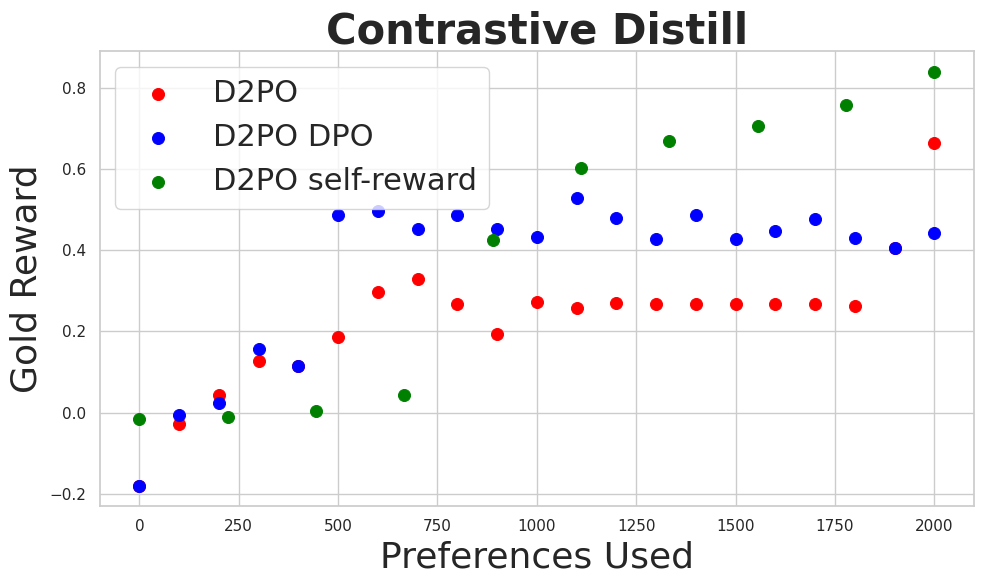

In [36]:
plot_methods(cdextrares, xlabel="Preferences Used", ylabel="Gold Reward", setname="Contrastive Distill", fname ='cdextra.pdf')

<Figure size 1000x600 with 0 Axes>

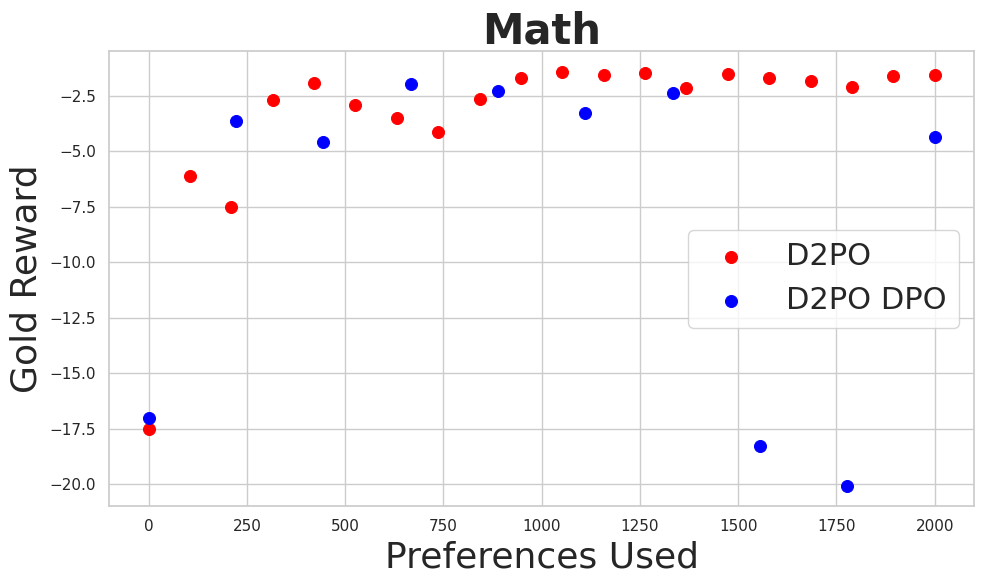

In [34]:
plot_methods(mathdiscrimbase, xlabel="Preferences Used", ylabel="Gold Reward", setname="Math", fname ='mathselfplot.pdf')

<Figure size 1000x600 with 0 Axes>

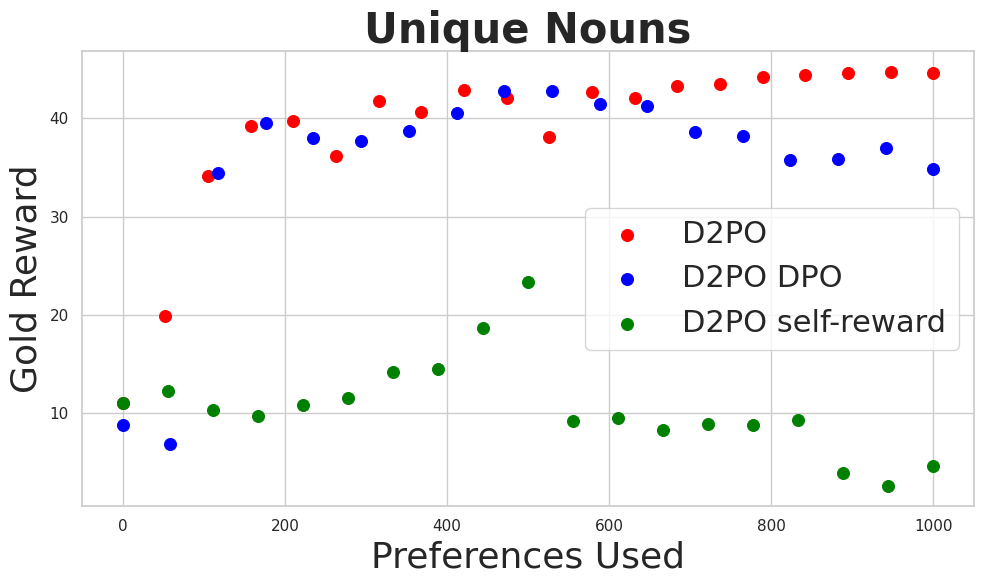

In [35]:
plot_methods(unndiscrimbase, xlabel="Preferences Used", ylabel="Gold Reward", setname="Unique Nouns", fname ='unnselfplot.pdf')

In [ ]:
# noun main plot
plot_methods(nounextrares, xlabel="Preferences Used", ylabel="Gold Reward", setname="Nouns", fname ='nounextra.pdf')

In [ ]:
# noun main plot
plot_methods(nounmainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Nouns", fname ='nounmain.pdf', point_labels=['DPO', "OPO w/ RM"], points=nounmainpoints)

<Figure size 1000x600 with 0 Axes>

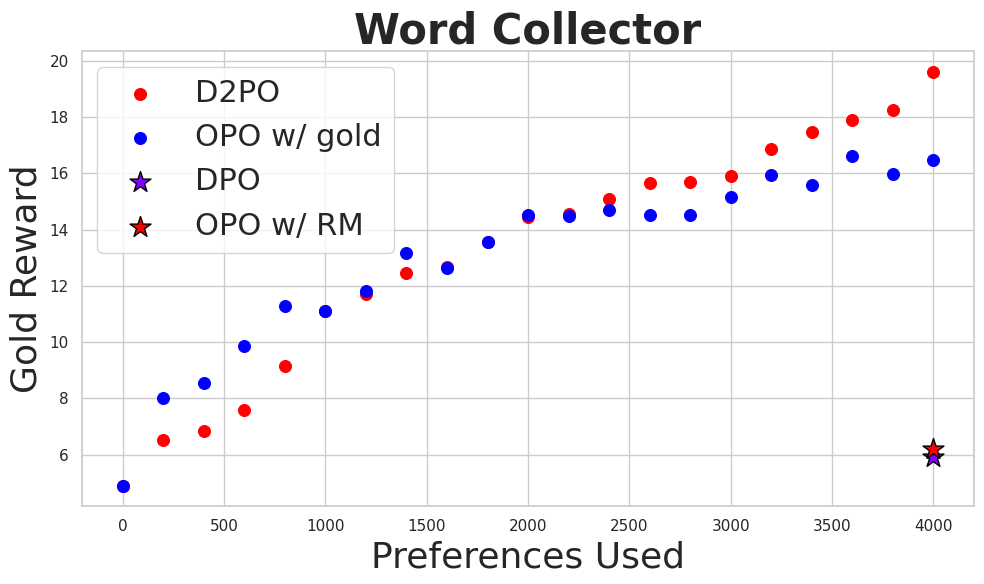

In [32]:
plot_methods(bowmainres, xlabel="Preferences Used", ylabel="Gold Reward", setname="Word Collector", fname ='bowmain.pdf', point_labels=['DPO', "OPO w/ RM"], points=bowmainpoints)

<Figure size 1000x600 with 0 Axes>

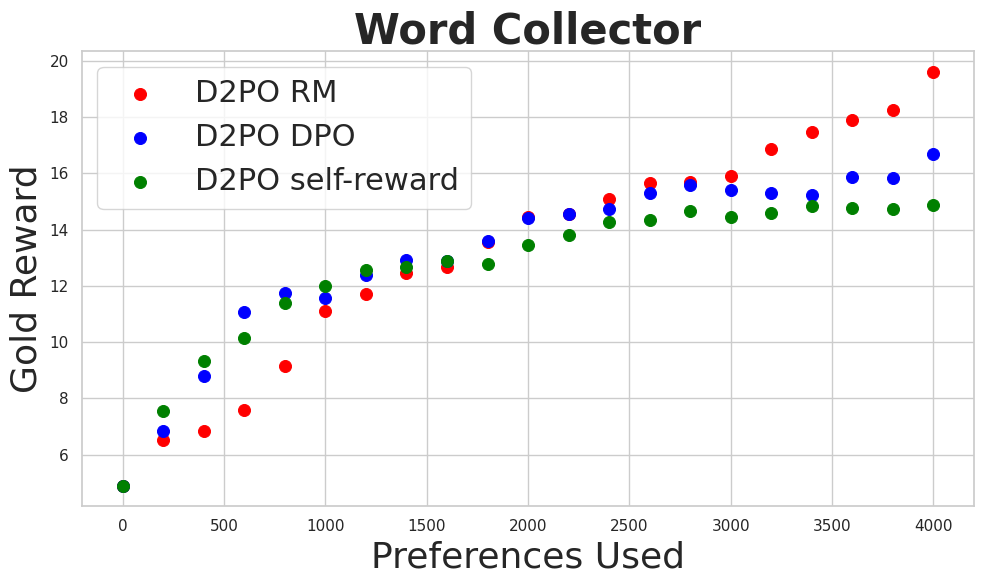

In [33]:
plot_methods(bowextrares, xlabel="Preferences Used", ylabel="Gold Reward", setname="Word Collector", fname ='bowextra.pdf', )

In [ ]:
# makeplot("../outputs/results/genouts/bagofwords", "ppo_conf_newalgo_goldb8_1ups", 25, 500, 25)
# keys = ["ppo_confnoun_newalgo_2_5_seed3", "ppo_confnoun_goldb8_4ups", "ppo_confnoun_goldb8_selfreward", "ppo_confnoun_newalgo_2_5_seed2"]
print(makeplot("../outputs/results/genouts/nouns", keys[3], 100, 1900, 100))

In [ ]:
# makeplot("../outputs/results/genouts/bagofwords", "ppo_conf_newalgo_goldb8_1ups", 25, 500, 25)
# keys = ["ppo_confnoun_newalgo_2_5_seed3", "ppo_confnoun_goldb8_4ups", "ppo_confnoun_goldb8_selfreward", "ppo_confnoun_newalgo_2_5_seed2"]
keys = ["ppo_contdistb8_moreupdates_4ups", "ppo_rand_cdist_10_5_activefix", "ppo_confcdist_goldb8_selfreward"]
print(makeplot("../outputs/results/genouts/contrastivedistill", keys[2], 25, 250, 25))

In [ ]:
listdir("../outputs/results/genouts/contrastivedistill/")

In [ ]:
makeplot("../outputs/results/genouts/bagofwords", "ppo_conf_newalgo_goldb8_1ups", 25, 500, 25)